<h1>1. Objectives </h1>

<h2> 1.1 Goals </h2>

<p>
1. Cluster pitchers and batters
2. 

<h2> 1.2 Sources </h2>

In [ ]:
1. Player fangraphs
savant
MLB.com lineups

<h1>2. Defining Functions </h1>

<h2> 2.1 Load Packages </h2>

In [311]:
from bs4 import BeautifulSoup
import requests
import re
import numpy as np
import pandas as pd
from selenium import webdriver
from selenium.common.exceptions import TimeoutException
from sklearn.linear_model import LinearRegression
import os
import time
import shutil
import statistics 
import matplotlib.pyplot as plt  
from datetime import date, timedelta

import unidecode
import seaborn as sns
import statsmodels.api as sm

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import export_text
from sklearn.tree import plot_tree
from sklearn.svm import SVC
from sklearn import metrics
import random

import warnings
warnings.filterwarnings('ignore')

<h2> 2.2 Define all functions </h2>

In [391]:
# Read pitcher advanced and battedball from local

def readPitchAdvanced(directory):
    count = 0
    for filename in os.listdir(directory):
        if 'csv' not in filename:
            continue
        f = os.path.join(directory, filename)
        if count == 0:
            df_read_pitch_adv = pd.read_csv(f)
        else:
            df_read_pitch_adv_tmp = pd.read_csv(f)
            df_read_pitch_adv = df_read_pitch_adv.append(df_read_pitch_adv_tmp,ignore_index=True)
        count += 1
    print("Load pitcher advanced - complete")
    return df_read_pitch_adv
        
def readPitchBattedBall(directory):
    count = 0
    for filename in os.listdir(directory):
        if 'csv' not in filename:
            continue
        f = os.path.join(directory, filename)
        if count == 0:
            df_read_pitch_bb = pd.read_csv(f)
        else:
            df_read_pitch_bb_tmp = pd.read_csv(f)
            df_read_pitch_bb = df_read_pitch_bb.append(df_read_pitch_bb_tmp,ignore_index=True)
        count += 1
    print("Load pitcher battedball - complete")
    return df_read_pitch_bb

# Load zone contact and chase rates from local
def loadPitchSavant(directory):
    savantData = pd.read_csv(directory)
    
    player = []
    # Clean up player names
    for i in range(len(savantData)):
        player_tmp = savantData[' first_name'][i][1:] + " " + savantData['last_name'][i]
        player.append(player_tmp)
    savantData['player'] = player
    savantData = savantData[['player','oz_swing_percent','iz_contact_percent']]
    # Change column names
    savantData = savantData.rename(columns={'oz_swing_percent': 'Chase%', 'iz_contact_percent':'IZ_Contact%'})
    
    print("Savant cleanup - complete")
    return savantData


def mergePitcherStats(df_read_pitch_adv, df_read_pitch_bb, savantData, handPosReport):  
    # Merge pitcher adv and battedball
    pitcherStats = pd.merge(df_read_pitch_adv,df_read_pitch_bb[['Player', 'Split','LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'IFH%',  'Pull%',
           'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%']], 
             left_on = ['Player','Split'], right_on=['Player','Split'], how = 'left').drop_duplicates().reset_index(drop=True)
    print("Advanced and battedball merge complete")
    
    # Merge with savant
    pitcherStats = pd.merge(pitcherStats,savantData, 
         left_on = ['Player'], right_on=['player'], how = 'left').drop_duplicates().reset_index(drop=True)
    print("Savant merge complete")
    
    # Merge pitcher adv and bb stats with position
    pitcherStats = pd.merge(pitcherStats,handPosReport[['PlayerName','Player_pos']],
                                                 left_on = ['Player'], right_on=['PlayerName'], how = 'left')
    pitcherStats = pitcherStats.drop(columns=['PlayerName'])
    print("Position merge complete")

    #Append batter hand to game log
    pitcherStats = pitcherStats[pitcherStats['Player_pos'] == 'SP'].dropna(subset  = ['Chase%']).reset_index(drop=True)
       
    print("All pitcher merge complete.")
    
    # Hand-pick metrics
    pitcherStats = pitcherStats[['Team', 'Player', 'Stat_cat', 'Bat/Pitch', 'Stat', 'Season', 'Split',
       'K/9', 'BB/9', 'K/BB', 'HR/9', 'K%', 'BB%', 'K-BB%', 'AVG', 'WHIP',
       'BABIP', 'LOB%', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB',
       'IFH%', 'Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%','Chase%', 'IZ_Contact%']]
    
    # Ensure only handedness is included rather than Home/Away or Month.
    pitcherStats = pitcherStats[pitcherStats['Stat'] == 'Handedness'].reset_index(drop = True)
    
    # Convert to float
    for i in pitcherStats.columns:
        for j in range(len(pitcherStats)):
            try:
                pitcherStats[i][j] = float(pitcherStats[i][j].strip('%'))/100
            except:
                continue
            
    print("Conversion to fload complete")
    
    #Mean value imputation for missing data
    for i in pitcherStats.columns:
        try:
            colMean = pitcherStats[i].mean()
        except:
            continue
        for j in range(len(pitcherStats)):
            if  pd.isna(pitcherStats[i][j]):
                pitcherStats[i][j] = colMean
    print("Mean imputation complete")
    
    # Create opponent handedness column for individual matchups.
    oppHandedness = []
    for i in range(len(pitcherStats)):
        pitcherStats['Player'][i] = unidecode.unidecode(pitcherStats['Player'][i])
        handedness_tmp = pitcherStats['Split'][i]
        handedness_tmp = handedness_tmp[3:4]
        oppHandedness.append(handedness_tmp)
    pitcherStats['oppHandedness'] = oppHandedness
    pitcherStats = pitcherStats.drop_duplicates(subset = ['Player', 'oppHandedness']).reset_index(drop = True)
    
    print("Opponent handedness created")
    
    return pitcherStats



def standardizedNumericPitcher(pitcherStats):
    pitcherStatsNumeric = pitcherStats[['K/9', 'BB/9', 'K/BB', 'HR/9', 'K%', 'BB%', 'K-BB%', 'AVG', 'WHIP',
       'BABIP', 'LOB%', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB',
       'IFH%', 'Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%',
       'Chase%', 'IZ_Contact%']]

    pitcherStats_scaled = pd.DataFrame()

    for i in pitcherStatsNumeric.columns:

        pitcherStats_scaled[i] = standardization(pitcherStatsNumeric[i])
    print("Standardization complete")

    return pitcherStats_scaled

# clustering function for both batters and pitchers
def clustering(n_clusters, random_state, stats_scaled):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(pitcherStats_scaled)
    cluster_map = pd.DataFrame()
    cluster_map['data_index'] = pitcherStats_scaled.index.values
    cluster_map['cluster'] = kmeans.labels_
    
    cluster_map['cluster'] = cluster_map['cluster']
    print("Clustering complete")
    print("Clusters mapped to row indices")
    return kmeans, cluster_map

def clusterCount(kmeans, stats_scaled):
    # RETURN number of players in each cluster
    kmeans.fit(stats_scaled)
    pred = kmeans.predict(stats_scaled)

    frame = pd.DataFrame({'cluster':pred})
    #frame['cluster'] = pred
    print("Count players in each cluster")
    return frame['cluster'].value_counts()


def plotClusterPitcher(pitcherStats_scaled,cluster_map , clusNum):
    #All groups
    means = pitcherStats_scaled.mean(axis = 0).to_list()

    # One subgroup example
    pitcherStats_clusterOne = pitcherStats_scaled.filter(cluster_map[cluster_map.cluster == clusNum].index, axis=0)
    means = pitcherStats_clusterOne.mean(axis = 0).to_list()

    # dataframe reshaping
    df = pd.melt(frame = pitcherStats_scaled,var_name = 'Stats',value_name = 'Value')

    # figure set-up
    fig, ax = plt.subplots()

    cols = ['K/9', 'BB/9', 'K/BB', 'HR/9', 'K%', 'BB%', 'K-BB%', 'AVG', 'WHIP',
           'BABIP', 'LOB%', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB',
           'IFH%', 'Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%',
           'Chase%', 'IZ_Contact%']

    # dot-plot
    b = sns.stripplot(ax = ax,data = df,x = 'Stats',y = 'Value',color=".8",size = 3,alpha=0.2,zorder=1)

    # mean plot
    ax.plot(cols, means, color = 'red', marker = 'o', linestyle = '', zorder=5)

    # show figure
    font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 10}
    plt.rc('font', **font)
    fig.set_figheight(8)
    fig.set_figwidth(16)
    ax.set(ylim=(-5, 5))
    
    plotTitle = "Cluster %s" % clusNum
    b.set_title(plotTitle,fontsize=40)
    b.set_xlabel("Stats",fontsize=25)
    b.set_ylabel("Value",fontsize=25)
    plt.show()
    
def getClusterPlayers(stats, cluster_map, clusterNumber):
    return stats.filter(cluster_map[cluster_map.cluster == clusterNumber].index, axis=0).drop_duplicates(subset=['Player','oppHandedness'])


# Write to local
def clusterToLocal(stats, cluster_map, directory):
    
    # TODO: remove files in directory first
    for i in range(len(np.unique(cluster_map['cluster']))):
        #cluster_map
        StatsCluster = clusterPlayers(stats, cluster_map, i)
        #Append cluster number
        StatsCluster['Cluster'] = i
        
        fileName = 'cluster' + str(i) + '.csv'
        pathName = directory + fileName
        
        #pitcherStatsCluster = pitcherStats.filter(cluster_map[cluster_map.cluster == i].index, axis=0)
        
        StatsCluster.to_csv(pathName, index = False)
    print("Write to local complete")


#Load handedness and positions from local
def readHandPosition(directory):
    handPosReport = pd.read_csv(directory)
    for i in range(len(handPosReport)):
        handPosReport['Player'][i] = unidecode.unidecode(handPosReport['Player'][i]) #uni-decode
    handPosReport = handPosReport.rename(columns={"Player": "PlayerName"})
    print("Handedness and position loaded")
    return handPosReport

def standardization(vector):
    return (vector - vector.mean())/ vector.std()

# Read batter advanced and batter battedball

def readBatAdvanced(directory):

    #directory = 'T:\\Baseball\\export\\7_13_export\\2022_bat_advanced'
    count = 0
    for filename in os.listdir(directory):
        if 'csv' not in filename:
            continue
        f = os.path.join(directory, filename)
        if count == 0:
            df_read_bat_adv = pd.read_csv(f)
        else:
            df_read_bat_adv_tmp = pd.read_csv(f)
            df_read_bat_adv = df_read_bat_adv.append(df_read_bat_adv_tmp,ignore_index=True)
        count += 1
    return df_read_bat_adv


def readBatBattedball(directory):

    #directory = 'T:\\Baseball\\export\\7_13_export\\2022_bat_battedball'
    count = 0
    for filename in os.listdir(directory):
        if 'csv' not in filename:
            continue
        f = os.path.join(directory, filename)
        if count == 0:
            df_read_bat_bb = pd.read_csv(f)
        else:
            df_read_bat_bb_tmp = pd.read_csv(f)
            df_read_bat_bb = df_read_bat_bb.append(df_read_bat_bb_tmp,ignore_index=True)
        count += 1
    return df_read_bat_bb

# Load batter savant data
def loadBatSavant(directory):
    # Load zone contact and chase rates
    savantData = pd.read_csv(directory)
    
    # Clean up player names
    player = []
    for i in range(len(savantData)):
        player_tmp = savantData[' first_name'][i][1:] + " " + savantData['last_name'][i]
        player.append(player_tmp)
    savantData['player'] = player
    # Change column names
    savantData = savantData[['player','exit_velocity_avg','launch_angle_avg','barrel_batted_rate']]
    savantData = savantData.rename(columns={'exit_velocity_avg': 'EV', 'launch_angle_avg':'LA','barrel_batted_rate':'Barrel%'})
    
    print("Savant cleanup - complete")
    return savantData


def mergeBatterStats(df_read_bat_adv, df_read_bat_bb, savantData, handPosReport):  
    # Merge batter adv and battedball
    batterStats = pd.merge(df_read_bat_adv,df_read_bat_bb[['Player', 'Split', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'IFH%', 'Pull%',
       'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%', 'Pitches', 'Balls','Strikes']], 
         left_on = ['Player','Split'], right_on=['Player','Split'], how = 'left').drop_duplicates().reset_index(drop=True)
    print("Advanced and battedball merge complete")
    
    # Merge with savant
    batterStats = pd.merge(batterStats,savantData, 
             left_on = ['Player'], right_on=['player'], how = 'left').drop_duplicates().reset_index(drop=True)
    print("Savant merge complete")
    
    # Merge with position
    batterStats = pd.merge(batterStats,handPosReport[['PlayerName','Player_pos']],
                                                 left_on = ['Player'], right_on=['PlayerName'], how = 'left')
    batterStats = batterStats.drop(columns=['PlayerName'])
    print("Position merge complete")
    
    print("All batter merge complete")
    
    # Hand-pick metrics
    batterStats = batterStats[['Team', 'Player', 'Stat_cat', 'Bat/Pitch', 'Stat', 'Season', 'Split',
       'BB%', 'K%', 'BB/K', 'AVG', 'OBP', 'SLG', 'OPS', 'ISO', 'BABIP','LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'IFH%',
       'Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%', 'EV', 'LA', 'Barrel%']] 
    # Convert to float
    for i in batterStats.columns:
        for j in range(len(batterStats)):
            try:
                batterStats[i][j] = float(batterStats[i][j].strip('%'))/100
            except:
                continue
    print("Conversion to fload complete")
            
    #Mean value imputation
    for i in batterStats.columns:
        try:
            colMean = batterStats[i].mean()
        except:
            continue
        for j in range(len(batterStats)):
            if  pd.isna(batterStats[i][j]):
                batterStats[i][j] = colMean
    print("Mean imputation complete")
    
    # Create opponent handedness column for individual matchups.
    oppHandedness = []
    for i in range(len(batterStats)):
        batterStats['Player'][i] = unidecode.unidecode(batterStats['Player'][i]) # Unicode conversion
        handedness_tmp = batterStats['Split'][i]
        handedness_tmp = handedness_tmp[3:4]
        oppHandedness.append(handedness_tmp)
    batterStats['oppHandedness'] = oppHandedness
    batterStats = batterStats.drop_duplicates(subset = ['Player', 'oppHandedness']).reset_index(drop = True)
    
    print("Opponent handedness created")  
    return batterStats
    
    
def standardization(vector):
    return (vector - vector.mean())/ vector.std()

def standardizedNumericBatter(batterStats):
    batterStatsNumeric = batterStats[['BB%', 'K%', 'BB/K', 'AVG', 'OBP', 'SLG', 'OPS', 'ISO', 'BABIP','LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'IFH%',
        'Oppo%',  'EV', 'LA', 'Barrel%']]
    # Other metrics to consider:
    #'Soft%', 'Med%', 'Hard%','Pull%', 'Cent%'
    
    batterStats_scaled = pd.DataFrame()
    for i in batterStatsNumeric.columns:
        batterStats_scaled[i] = standardization(batterStatsNumeric[i])  
        
    print("Standardization complete")

    return batterStats_scaled


def plotClusterBatter(batterStats_scaled, cluster_map , clusNum):
    #All groups
    means = batterStats_scaled.mean(axis = 0).to_list()

    # One subgroup example
    batterStats_clusterOne = batterStats_scaled.filter(cluster_map[cluster_map.cluster == clusNum].index, axis=0)
    means = batterStats_clusterOne.mean(axis = 0).to_list()

    # dataframe reshaping
    df = pd.melt(frame = batterStats_scaled,var_name = 'Stats',value_name = 'Value')

    # figure set-up
    fig, ax = plt.subplots()

    cols = ['BB%', 'K%', 'BB/K', 'AVG', 'OBP', 'SLG', 'OPS', 'ISO', 'BABIP','LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'IFH%',
            'Oppo%',  'EV', 'LA', 'Barrel%']

    # dot-plot
    b = sns.stripplot(ax = ax,data = df,x = 'Stats',y = 'Value',color=".8",size = 3,alpha=0.2,zorder=1)

    # mean plot
    ax.plot(cols, means, color = 'red', marker = 'o', linestyle = '',zorder=5)

    # show figure
    font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 10}
    plt.rc('font', **font)
    fig.set_figheight(10)
    fig.set_figwidth(20)
    ax.set(ylim=(-5, 5))
    plotTitle = "Cluster %s" % clusNum
    b.set_title(plotTitle,fontsize=40)
    b.set_xlabel("Stats",fontsize=25)
    b.set_ylabel("Value",fontsize=25)
    plt.show()

    
# Read and concatenate all clusters for pitchers/batters.
def readClusterPitcher():
    #pitchers
    directory = 'Data\\Cluster\\Pitchers'
    count = 0
    for filename in os.listdir(directory):
        if 'csv' not in filename:
            continue
        f = os.path.join(directory, filename)
        if count == 0:
            df_read_pitcher_cluster = pd.read_csv(f)
        else:
            df_read_pitcher_cluster_tmp = pd.read_csv(f)
            df_read_pitcher_cluster = df_read_pitcher_cluster.append(df_read_pitcher_cluster_tmp,ignore_index=True)
        count += 1
    # Ensure unidecode conversion
    for i in range(len(df_read_pitcher_cluster)):
        df_read_pitcher_cluster['Player'][i] = unidecode.unidecode(df_read_pitcher_cluster['Player'][i]) # Unicode conversion

    # Ensure only handedness is included. Drop duplicated player-handedness pairs.
    df_read_pitcher_cluster = df_read_pitcher_cluster[df_read_pitcher_cluster['Stat'] == 'Handedness']
    df_read_pitcher_cluster = df_read_pitcher_cluster.drop_duplicates(subset = ['Player','oppHandedness']).reset_index(drop = True)

    # Hand-pick variables for modeling
    #df_read_pitcher_cluster = df_read_pitcher_cluster[['Team', 'Player', 'Cluster', 'oppHandedness',
    #   'K/9', 'BB/9', 'K/BB', 'HR/9', 'K%', 'BB%', 'K-BB%', 'AVG', 'WHIP',
    #   'BABIP', 'LOB%', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'IFH%', 'Pull%',
    #   'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%', 'Chase%', 'IZ_Contact%'
    #   ]]
    
    
    return df_read_pitcher_cluster

def readClusterBatter():
    # batters
    directory = 'Data\\Cluster\\Batters'
    count = 0
    for filename in os.listdir(directory):
        if 'csv' not in filename:
            continue
        f = os.path.join(directory, filename)
        if count == 0:
            df_read_batter_cluster = pd.read_csv(f)
        else:
            df_read_batter_cluster_tmp = pd.read_csv(f)
            df_read_batter_cluster = df_read_batter_cluster.append(df_read_batter_cluster_tmp,ignore_index=True)
        count += 1
    # Ensure unidecode conversion
    for i in range(len(df_read_batter_cluster)):
        df_read_batter_cluster['Player'][i] = unidecode.unidecode(df_read_batter_cluster['Player'][i]) # Unicode conversion
        
    # Ensure only handedness is included. Drop duplicated player-handedness pairs.
    df_read_batter_cluster = df_read_batter_cluster[df_read_pitcher_cluster['Stat'] == 'Handedness']
    df_read_batter_cluster = df_read_batter_cluster.drop_duplicates(subset = ['Player','oppHandedness']).reset_index(drop = True)

    return df_read_batter_cluster

# Load daily matchup raw data from the designated folder based on the file name
def loadDailyMatchupRaw(filename):
    directory = "Data\\DailyMatchupRaw\\" + filename
    pitcher_batter_matchup_today = pd.read_csv(directory)
    return pitcher_batter_matchup_today

def baseballXGB(random_state, max_depth, n_estimators, min_samples_leaf, pitcher_batter_matchup_today, \
                pitcherBatterMatchupDataAllSeason, df_read_pitcher_cluster, df_read_batter_cluster):

    #Initialize prediction columns
    PA_pred = []
    AB_pred = []
    H_pred = []
    B1_pred = []
    B2_pred = []
    B3_pred = []
    HR_pred = []
    R_pred = []
    RBI_pred = []
    BB_pred = []
    SO_pred = []
    HBP_pred = []
    SB_pred = []

    for i in range(len(pitcher_batter_matchup_today)):
        #Identify pitcher
        pitcher = pitcher_batter_matchup_today['Pitcher'][i]
        pitcherHand = pitcher_batter_matchup_today['Pitcher_hand'][i]
        #Identify batter
        oppBatter = pitcher_batter_matchup_today['Batter'][i]
        batterHand = pitcher_batter_matchup_today['Batter_hand'][i]

        #Test
        #lenMatchup = len(pitcher_batter_matchup_today)
        #pitcher = pitcher_batter_matchup_today['Pitcher'][180]
        #pitcherHand = pitcher_batter_matchup_today['Pitcher_hand'][180]
        #Identify batter
        #oppBatter = pitcher_batter_matchup_today['Batter'][180]
        #batterHand = pitcher_batter_matchup_today['Batter_hand'][180]

        #First case: has this batter faced this particular pitcher in enough games?

        thisBattersFacingThisPitcherClusterData = pitcherBatterMatchupDataAllSeason[(pitcherBatterMatchupDataAllSeason['Pitcher'] == pitcher) & (pitcherBatterMatchupDataAllSeason['Batter'] == oppBatter)]
        #Else If mininum not met, find game logs of this batter facing this pitcher cluster
        if len(thisBattersFacingThisPitcherClusterData) < 5:

            # Find all batters who have faced this cluster of pitchers
            if df_read_pitcher_cluster[(df_read_pitcher_cluster['Player'] == pitcher) & \
                                      (df_read_pitcher_cluster['oppHandedness'] == batterHand)]['Cluster'].reset_index(drop = True).tolist() == []:
                H_pred.append(np.nan) #append predicted values
                PA_pred.append(np.nan)
                AB_pred.append(np.nan)
                B1_pred.append(np.nan)
                B2_pred.append(np.nan)
                B3_pred.append(np.nan)
                HR_pred.append(np.nan)
                R_pred.append(np.nan)
                RBI_pred.append(np.nan)
                BB_pred.append(np.nan)
                SO_pred.append(np.nan)
                HBP_pred.append(np.nan)
                SB_pred.append(np.nan)

                continue
            #Find which cluster the opponent pitcher is in.
            pitcherCluster = df_read_pitcher_cluster[(df_read_pitcher_cluster['Player'] == pitcher) & \
                                      (df_read_pitcher_cluster['oppHandedness'] == batterHand)]['Cluster'].reset_index(drop = True).tolist()[0]

            #Find which pitchers are in this cluster
            dfPitcherThisCluster = df_read_pitcher_cluster[df_read_pitcher_cluster['Cluster'] == pitcherCluster]
            listPitcherThisCluster = dfPitcherThisCluster['Player'].tolist()

            #Find game logs of this group of pitchers
            allBattersFacingThisPitcherClusterData = pitcherBatterMatchupDataAllSeason[pitcherBatterMatchupDataAllSeason['Pitcher'].isin(listPitcherThisCluster)]

            thisBattersFacingThisPitcherClusterData = allBattersFacingThisPitcherClusterData[allBattersFacingThisPitcherClusterData['Batter'] == oppBatter]


        # If mininum not met, find game logs of this batter cluster facing this pitcher cluster
        if len(thisBattersFacingThisPitcherClusterData) < 20:

            #First find the cluster of batters.
            if df_read_batter_cluster[(df_read_batter_cluster['Player'] == oppBatter) &\
                                     (df_read_batter_cluster['oppHandedness'] == pitcherHand)]['Cluster'].reset_index(drop = True).tolist() == []:
                H_pred.append(np.nan) #append predicted values
                PA_pred.append(np.nan)
                AB_pred.append(np.nan)
                B1_pred.append(np.nan)
                B2_pred.append(np.nan)
                B3_pred.append(np.nan)
                HR_pred.append(np.nan)
                R_pred.append(np.nan)
                RBI_pred.append(np.nan)
                BB_pred.append(np.nan)
                SO_pred.append(np.nan)
                HBP_pred.append(np.nan)
                SB_pred.append(np.nan)
                continue
            oppBatterCluster = df_read_batter_cluster[(df_read_batter_cluster['Player'] == oppBatter) &\
                                     (df_read_batter_cluster['oppHandedness'] == pitcherHand)]['Cluster'].reset_index(drop = True).tolist()[0]
            dfBatterThisCluster = df_read_batter_cluster[df_read_batter_cluster['Cluster'] == oppBatterCluster]
            listBatterThisCluster = dfBatterThisCluster['Player'].tolist()
            thisBattersFacingThisPitcherClusterData = allBattersFacingThisPitcherClusterData[allBattersFacingThisPitcherClusterData['Batter'].isin(listBatterThisCluster)]
            thisBattersFacingThisPitcherClusterData = thisBattersFacingThisPitcherClusterData.drop_duplicates(subset = ['Pitcher','Batter','Date'])
        #Take the average
        #Make for loop
        
        print("Pitcher Name:", pitcher)
        print("Pitcher Cluster:",pitcherCluster)
        print("Batter:",oppBatter)
        print("Sample size:", len(thisBattersFacingThisPitcherClusterData))
        print("\n")

        #Get data and target with season average stats based on the filtered cluster data
        thisBattersFacingThisPitcherClusterData2 = pd.merge(thisBattersFacingThisPitcherClusterData, pitcherStats, left_on = ['Pitcher','Hand_batter'], 
                             right_on=['Player', 'oppHandedness'], how = 'left')
        thisBattersFacingThisPitcherClusterData2 = pd.merge(thisBattersFacingThisPitcherClusterData2, batterStats, left_on = ['Batter','Hand_pitcher'], 
                             right_on=['Player','oppHandedness'], how = 'left')
        thisBattersFacingThisPitcherClusterData2 = thisBattersFacingThisPitcherClusterData2.drop_duplicates(subset = ['Pitcher','Batter','Date'])
        thisBattersFacingThisPitcherClusterData2 = thisBattersFacingThisPitcherClusterData2.dropna().reset_index(drop = True)

        # Hand-pick train data fields  
        train_data = thisBattersFacingThisPitcherClusterData2[['K/9', 'BB/9', 'K/BB', 'HR/9', 'K%_x',
           'BB%_x', 'K-BB%', 'AVG_x', 'WHIP', 'BABIP_x', 'BB%_y', 'K%_y', 
            'BB/K', 'AVG_y', 'OBP', 'SLG', 'OPS', 'ISO',
           'BABIP_y', 'LD%_y', 'GB%_y', 'FB%_y', 'IFFB%_y', 'HR/FB_y']]

        #Other metrics to consider
        #'LOB%', 'LD%_x', 'GB%_x','FB%_x', 'IFFB%_x', 'HR/FB_x', 'IFH%_x', 'Pull%_x', 'Cent%_x',
          # 'Oppo%_x', 'Soft%_x', 'Med%_x', 'Hard%_x', 'Chase%', 'IZ_Contact%', 'IFH%_y',
          # 'Pull%_y', 'Cent%_y', 'Oppo%_y', 'Soft%_y', 'Med%_y', 'Hard%_y', 'EV',
          # 'LA', 'Barrel%'



        grid_gb = GradientBoostingClassifier(random_state = 42, max_depth = 5, n_estimators = 100, min_samples_leaf = 5)


        # Get test data
        matchupToTest = pitcher_batter_matchup_today[(pitcher_batter_matchup_today['Pitcher'] == pitcher) & (pitcher_batter_matchup_today['Batter'] == oppBatter)]
        matchupToTest = matchupToTest[['Pitcher','Batter']]
        matchupToTest = pd.merge(matchupToTest, pitcherStats, left_on = ['Pitcher'], 
                                 right_on=['Player'], how = 'left')
        matchupToTest = pd.merge(matchupToTest, batterStats, left_on = ['Batter'], 
                                 right_on=['Player'], how = 'left')
        matchupToTest = matchupToTest.drop_duplicates(subset = ['Pitcher','Batter'])
        matchupToTest = matchupToTest.reset_index(drop = True)


        # Hand-pick test data fields - same as train data
        matchupToTest = matchupToTest[['K/9', 'BB/9', 'K/BB', 'HR/9', 'K%_x',
           'BB%_x', 'K-BB%', 'AVG_x', 'WHIP', 'BABIP_x', 'BB%_y', 'K%_y', 
            'BB/K', 'AVG_y', 'OBP', 'SLG', 'OPS', 'ISO',
           'BABIP_y', 'LD%_y', 'GB%_y', 'FB%_y', 'IFFB%_y', 'HR/FB_y']]

         #Other metrics to consider
        #'LOB%', 'LD%_x', 'GB%_x','FB%_x', 'IFFB%_x', 'HR/FB_x', 'IFH%_x', 'Pull%_x', 'Cent%_x',
          # 'Oppo%_x', 'Soft%_x', 'Med%_x', 'Hard%_x', 'Chase%', 'IZ_Contact%', 'IFH%_y',
          # 'Pull%_y', 'Cent%_y', 'Oppo%_y', 'Soft%_y', 'Med%_y', 'Hard%_y', 'EV',
          # 'LA', 'Barrel%'

        if matchupToTest.isna().values.any():
            H_pred.append('')
            PA_pred.append('')
            AB_pred.append('')
            B1_pred.append('')    
            B2_pred.append('')    
            B3_pred.append('')
            HR_pred.append('')
            R_pred.append('')
            RBI_pred.append('')    
            BB_pred.append('')
            SO_pred.append('')
            HBP_pred.append('')  
            SB_pred.append('')
            continue

        #Test data initialization complete

        train_target = thisBattersFacingThisPitcherClusterData2['H_batter'].values
        grid_gb_result = grid_gb.fit(train_data, train_target)
        xgbPred = grid_gb_result.predict(matchupToTest).item()
        H_pred.append(xgbPred)

        train_target = thisBattersFacingThisPitcherClusterData2['PA_batter'].values
        grid_gb_result = grid_gb.fit(train_data, train_target)
        xgbPred = grid_gb_result.predict(matchupToTest).item()
        PA_pred.append(xgbPred)

        train_target = thisBattersFacingThisPitcherClusterData2['AB_batter'].values
        try:
            grid_gb_result = grid_gb.fit(train_data, train_target)
            xgbPred = grid_gb_result.predict(matchupToTest).item()
            AB_pred.append(xgbPred)
        except:
            AB_pred.append('')

        train_target = thisBattersFacingThisPitcherClusterData2['1B_batter'].values
        try:
            grid_gb_result = grid_gb.fit(train_data, train_target)
            xgbPred = grid_gb_result.predict(matchupToTest).item()
            B1_pred.append(xgbPred)
        except:
            B1_pred.append('')

        train_target = thisBattersFacingThisPitcherClusterData2['2B_batter'].values
        try:
            grid_gb_result = grid_gb.fit(train_data, train_target)
            xgbPred = grid_gb_result.predict(matchupToTest).item()    
            B2_pred.append(xgbPred)
        except:
            B2_pred.append('')

        train_target = thisBattersFacingThisPitcherClusterData2['3B_batter'].values
        try:
            grid_gb_result = grid_gb.fit(train_data, train_target)
            xgbPred = grid_gb_result.predict(matchupToTest).item()    
            B3_pred.append(xgbPred)
        except:
            B3_pred.append('')     

        train_target = thisBattersFacingThisPitcherClusterData2['HR_batter'].values
        try:
            grid_gb_result = grid_gb.fit(train_data, train_target)
            xgbPred = grid_gb_result.predict(matchupToTest).item()  
            HR_pred.append(xgbPred)
        except:
            HR_pred.append('')    

        train_target = thisBattersFacingThisPitcherClusterData2['R_batter'].values
        try:
            grid_gb_result = grid_gb.fit(train_data, train_target)
            xgbPred = grid_gb_result.predict(matchupToTest).item()  
            R_pred.append(xgbPred)
        except:
            R_pred.append('')     

        train_target = thisBattersFacingThisPitcherClusterData2['RBI_batter'].values
        try:
            grid_gb_result = grid_gb.fit(train_data, train_target)
            xgbPred = grid_gb_result.predict(matchupToTest).item()  
            RBI_pred.append(xgbPred)    
        except:
            RBI_pred.append('')     

        train_target = thisBattersFacingThisPitcherClusterData2['BB_batter'].values
        try:
            grid_gb_result = grid_gb.fit(train_data, train_target)
            xgbPred = grid_gb_result.predict(matchupToTest).item()  
            BB_pred.append(xgbPred)
        except:
            BB_pred.append('')        

        train_target = thisBattersFacingThisPitcherClusterData2['SO_batter'].values
        try:
            grid_gb_result = grid_gb.fit(train_data, train_target)
            xgbPred = grid_gb_result.predict(matchupToTest).item()
            SO_pred.append(xgbPred)
        except:
            SO_pred.append('')

        train_target = thisBattersFacingThisPitcherClusterData2['HBP_batter'].values
        try:
            grid_gb_result = grid_gb.fit(train_data, train_target)
            xgbPred = grid_gb_result.predict(matchupToTest).item()
            HBP_pred.append(xgbPred)
        except:
            HBP_pred.append('')

        train_target = thisBattersFacingThisPitcherClusterData2['SB_batter'].values
        try:
            grid_gb_result = grid_gb.fit(train_data, train_target)
            xgbPred = grid_gb_result.predict(matchupToTest).item()    
            SB_pred.append(xgbPred)  
        except:
            SB_pred.append('') 

    pitcher_batter_matchup_today['H_pred'] = H_pred
    pitcher_batter_matchup_today['PA_pred'] = PA_pred
    pitcher_batter_matchup_today['AB_pred'] = AB_pred
    pitcher_batter_matchup_today['B1_pred'] = B1_pred
    pitcher_batter_matchup_today['B2_pred'] = B2_pred
    pitcher_batter_matchup_today['B3_pred'] = B3_pred
    pitcher_batter_matchup_today['HR_pred'] = HR_pred
    pitcher_batter_matchup_today['R_pred'] = R_pred
    pitcher_batter_matchup_today['RBI_pred'] = RBI_pred
    pitcher_batter_matchup_today['BB_pred'] = BB_pred
    pitcher_batter_matchup_today['SO_pred'] = SO_pred
    pitcher_batter_matchup_today['HBP_pred'] = HBP_pred
    pitcher_batter_matchup_today['SB_pred'] = SB_pred
    
    #Hand-pick columns to export
    pitcher_batter_matchup_today = pitcher_batter_matchup_today[['Pitcher', 'Pitcher_hand', 'Pitcher_team', 'Team', 'Away/Home',
       'Opponent', 'Date', 'Batter', 'Batter_hand', 'Batter_team', 'Player',
       'Season', 'H_pred', 'PA_pred',
       'AB_pred',  'B2_pred', 'B3_pred', 'HR_pred', 'R_pred',
       'RBI_pred', 'BB_pred', 'SO_pred', 'HBP_pred', 'SB_pred']]
    
    
    pitcher_batter_matchup_today.to_csv("Predictions\\DailyPrediction.csv", index = False)
    return pitcher_batter_matchup_today
    print("Done!")

<h1>3. Data Preparations for Clustering</h1>

<h2>3.1 Load and merge pitcher averege data from multiple sources for clustering</h2>

<p>
1. Load average advanced and battedball data for pitchers from a local directory, which should be scraped and updated from Fangraphs regularly. See "Data\fangraphs.ipynb".
<p>    
2. Load BaseballSavent data for pitcher tendencies such as zone contact and chase rates. Data should be mass-downloaded and saved to local as .csv regularly. https://baseballsavant.mlb.com/   
<p>    
3. The handedness file includes both handedness and positions for all players from the Fangraphs roster page. For data maintenance, see "Data\fangraphs.ipynb".

In [352]:
# Load Fangraphs data from local
df_read_pitch_adv = readPitchAdvanced('Data\\Split\\2022_pitch_advanced')
df_read_pitch_bb = readPitchBattedBall('Data\\Split\\2022_pitch_battedball')

# Load pitcher savant data from local for zone contact and chase rates
savantData = loadPitchSavant('Data\\Savant\\savantPitcher.csv') 

# Load handedness and position for latest roster
handPosReport = readHandPosition("Data\\Handedness\\handednessFangraphs.csv")

# Merge pitcher data
pitcherStats = mergePitcherStats(df_read_pitch_adv, df_read_pitch_bb,savantData, handPosReport)

# Standardization for clustering
pitcherStats_scaled = standardizedNumericPitcher(pitcherStats)

Load pitcher advanced - complete
Load pitcher battedball - complete
Savant cleanup - complete
Handedness and position loaded
Advanced and battedball merge complete
Savant merge complete
Position merge complete
All pitcher merge complete.
Conversion to fload complete
Mean imputation complete
Opponent handedness created
Standardization complete


<h2>3.2 Load and merge pitcher averege data from multiple sources for clustering</h2>

<p>
1. The process mirrors pitcher data. 
<p>    
2. Savant tendency metrics selected are exit volocity, launch angels, and barrel rates.

In [353]:
df_read_bat_adv = readBatAdvanced('Data\\Split\\2022_bat_advanced')
df_read_bat_bb = readBatBattedball('Data\\Split\\2022_bat_battedball')
savantData = loadBatSavant('Data\\Savant\\savantBatter.csv')
batterStats = mergeBatterStats(df_read_bat_adv, df_read_bat_bb, savantData, handPosReport)
batterStats_scaled = standardizedNumericBatter(batterStats)

Savant cleanup - complete
Advanced and battedball merge complete
Savant merge complete
Position merge complete
All batter merge complete
Conversion to fload complete
Mean imputation complete
Opponent handedness created
Standardization complete


 <h1>4. Clustering </h1>

 <h2>4.1 Pitcher Clustering </h2>

<p>
The first argument is the number of clusters. 12 seems to be a good number.
<p>   
Also below are helper functions for revewing the clusters.

In [364]:
# Run k-means clustering. 12 is the number of clusters.
kmeans,cluster_map = clustering(12, 42, pitcherStats_scaled)
# Save to pitcher cluster directory
directory = 'Data\\Cluster\\Pitchers\\'
clusterToLocal(pitcherStats, cluster_map, directory)

Clustering complete
Clusters mapped to row indices
Write to local complete


In [370]:
# A better clustering method should reduce the inertia
kmeans.inertia_

4995.723541803967

In [371]:
# Cound the number of players within each cluster.
clusterCount(kmeans, pitcherStats_scaled)

Count players in each cluster


3     53
0     49
1     45
9     45
2     42
4     35
10    29
6     27
11     7
5      2
8      1
7      1
Name: cluster, dtype: int64

In [372]:
# Return players in the chosen cluster
clusterPlayers(pitcherStats, cluster_map, 3)

,Team,Player,Stat_cat,Bat/Pitch,Stat,Season,Split,K/9,BB/9,K/BB,...,IFH%,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%,Chase%,IZ_Contact%,oppHandedness
7,LOS ANGELES ANGELS,Noah Syndergaard,advanced,Pitcher,Handedness,2022,vs R,7.51,2.23,3.36,...,0.086,0.459,0.361,0.18,0.158,0.519,0.323,28.1,81.5,R
13,HOUSTON ASTROS,Justin Verlander,advanced,Pitcher,Handedness,2022,vs R,7.74,1.15,6.71,...,0.031,0.314,0.403,0.283,0.182,0.516,0.302,29.5,80.4,R
23,OAKLAND ATHLETICS,Cole Irvin,advanced,Pitcher,Handedness,2022,vs R,6.10,1.82,3.36,...,0.084,0.381,0.363,0.256,0.121,0.52,0.359,29.7,82.1,R
26,OAKLAND ATHLETICS,Paul Blackburn,advanced,Pitcher,Handedness,2022,vs L,7.63,2.47,3.08,...,0.036,0.407,0.378,0.215,0.163,0.548,0.289,26.8,83.8,L
31,TORONTO BLUE JAYS,Ross Stripling,advanced,Pitcher,Handedness,2022,vs R,7.71,2.04,3.78,...,0.066,0.384,0.344,0.272,0.168,0.488,0.344,33.3,84.6,R
32,TORONTO BLUE JAYS,Kevin Gausman,advanced,Pitcher,Handedness,2022,vs L,7.51,0.70,10.67,...,0.137,0.353,0.431,0.216,0.181,0.56,0.259,42.0,79.3,L
43,ATLANTA BRAVES,Max Fried,advanced,Pitcher,Handedness,2022,vs R,8.17,1.76,4.65,...,0.06,0.378,0.355,0.267,0.199,0.534,0.267,34.7,84.7,R
56,MILWAUKEE BREWERS,Eric Lauer,advanced,Pitcher,Handedness,2022,vs L,12.08,4.26,2.83,...,0.063,0.406,0.469,0.125,0.344,0.375,0.281,29.3,78.0,L
72,ST. LOUIS CARDINALS,Miles Mikolas,advanced,Pitcher,Handedness,2022,vs L,6.51,1.43,4.56,...,0.072,0.433,0.298,0.269,0.228,0.526,0.246,28.6,87.0,L
80,CHICAGO CUBS,Drew Smyly,advanced,Pitcher,Handedness,2022,vs L,3.75,3.00,1.25,...,0.0,0.385,0.41,0.205,0.205,0.385,0.41,32.4,81.1,L


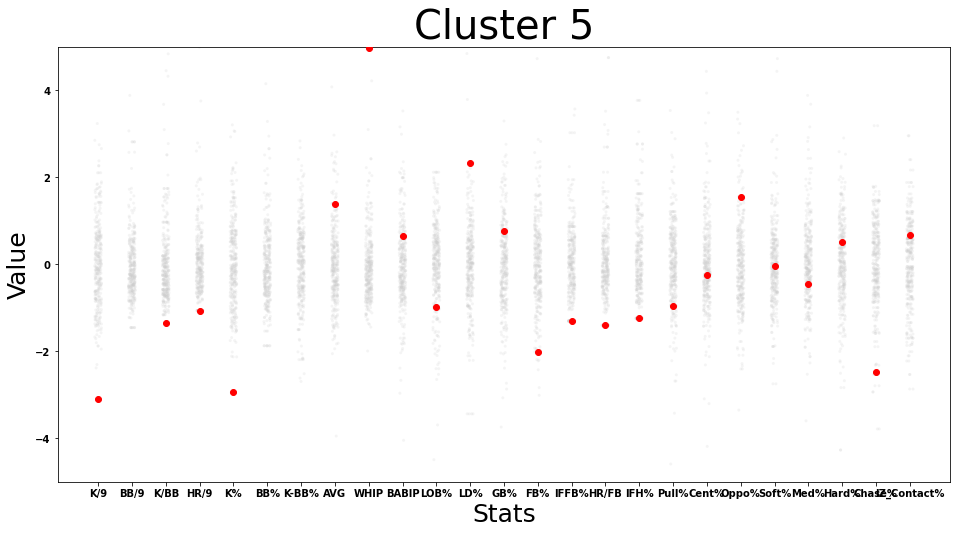

In [373]:
plotClusterPitcher(pitcherStats_scaled,cluster_map ,  5)

 <h2>4.2 Batter Clustering </h2>

<p>
Batter clustering mirrors pitcher clustering described above.

In [375]:
# 20 clusters for batters
kmeans,cluster_map = clustering(20, 42, batterStats_scaled)
# Save to batter cluster directory
directory = 'Data\\Cluster\\Batters\\'
clusterToLocal(batterStats, cluster_map, directory)

Clustering complete
Clusters mapped to row indices
Write to local complete


In [376]:
kmeans.inertia_

4179.303365373523

In [377]:
clusterCount(kmeans, batterStats_scaled)

Count players in each cluster


1     171
15    148
2      94
9      87
14     87
8      67
3      64
4      59
18     49
13     45
10     43
6      43
7      39
17     15
12      6
0       5
19      4
11      2
5       1
16      1
Name: cluster, dtype: int64

In [378]:
clusterPlayers(batterStats, cluster_map, 3)

,Team,Player,Stat_cat,Bat/Pitch,Stat,Season,Split,BB%,K%,BB/K,...,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%,EV,LA,Barrel%,oppHandedness
5,HOUSTON ASTROS,Kyle Tucker,advanced,Batter,Handedness,2022,vs R as L,0.142,0.174,0.82,...,0.427,0.347,0.227,0.18,0.473,0.347,89.500000,21.400000,11.300000,R
7,HOUSTON ASTROS,Alex Bregman,advanced,Batter,Handedness,2022,vs R as R,0.149,0.128,1.17,...,0.518,0.259,0.223,0.139,0.512,0.349,89.800000,18.900000,7.400000,R
10,HOUSTON ASTROS,J.J. Matijevic,advanced,Batter,Handedness,2022,vs L as L,0.167,0.5,0.33,...,0.0,0.5,0.5,0.5,0.0,0.5,94.500000,16.700000,6.300000,L
26,HOUSTON ASTROS,Jason Castro,advanced,Batter,Handedness,2022,vs L as L,0.0,0.667,0.00,...,0.333,0.0,0.667,0.333,0.667,0.0,88.600000,10.000000,5.100000,L
31,HOUSTON ASTROS,Michael Brantley,advanced,Batter,Handedness,2022,vs R as L,0.126,0.1,1.26,...,0.361,0.408,0.231,0.122,0.537,0.34,88.489831,12.985492,7.555525,R
33,HOUSTON ASTROS,Blake Taylor,advanced,Batter,Handedness,2022,vs R as L,0.074,0.21,0.35,...,0.316,0.404,0.281,0.07,0.579,0.351,88.489831,12.985492,7.555525,R
43,OAKLAND ATHLETICS,Elvis Andrus,advanced,Batter,Handedness,2022,vs R as R,0.079,0.138,0.57,...,0.418,0.323,0.259,0.209,0.525,0.266,88.200000,14.200000,3.600000,R
47,OAKLAND ATHLETICS,Tony Kemp,advanced,Batter,Handedness,2022,vs R as L,0.081,0.102,0.80,...,0.426,0.33,0.244,0.188,0.629,0.183,83.800000,16.300000,0.900000,R
67,TORONTO BLUE JAYS,Bo Bichette,advanced,Batter,Handedness,2022,vs R as R,0.052,0.24,0.22,...,0.313,0.396,0.291,0.096,0.552,0.352,91.600000,8.500000,10.000000,R
78,TORONTO BLUE JAYS,Santiago Espinal,advanced,Batter,Handedness,2022,vs L as R,0.098,0.122,0.80,...,0.5,0.344,0.156,0.156,0.531,0.313,86.800000,14.500000,4.300000,L


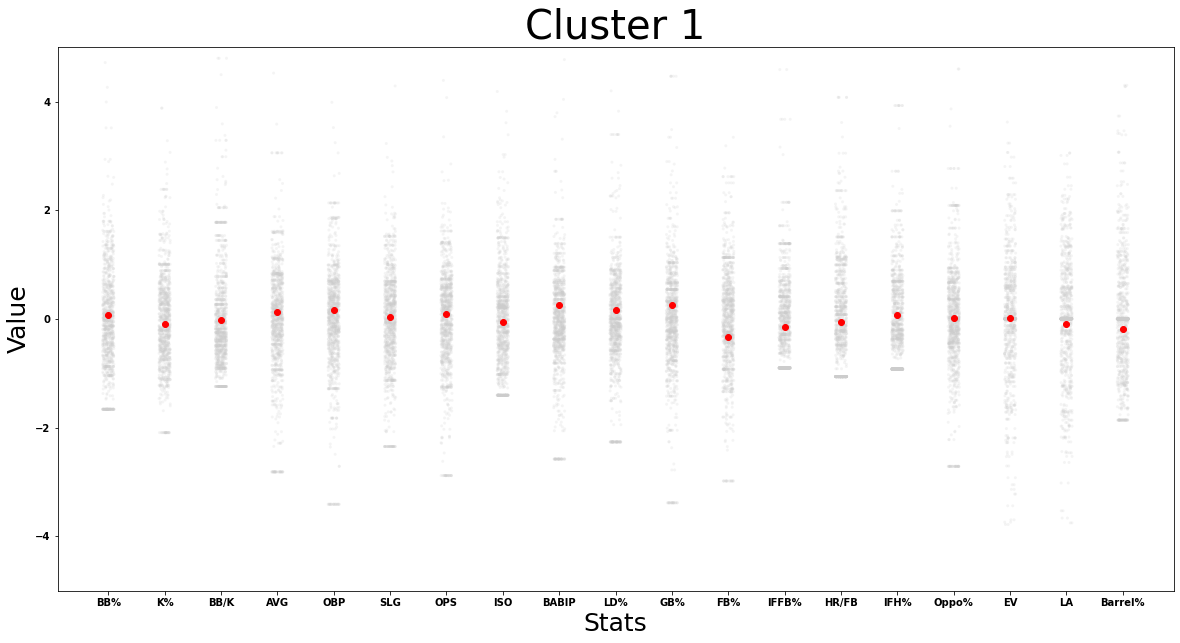

In [379]:
plotClusterBatter(batterStats_scaled, cluster_map , 1)

 <h1>5. Data Preparation for ML Models </h1>

<p>
1. Load raw daily matchup data, to which the predictions will be added. Scraped daily from MLB daily lineups. See "Scraping\dailyLineups.ipynb"
<p>
2. Combine clustering data for pitchers and batters
<p>
3. Load pre-processed game log data from 2020-2022 seasons. See "Data\PlayerGameLogs.ipynb".

In [385]:
# Raw daily matchup data,
pitcher_batter_matchup_today = loadDailyMatchupRaw("pitcher_analysis_2022_7_17.csv")

In [387]:
# Combine clustering data for pitchers and batters
df_read_pitcher_cluster = readClusterPitcher()
df_read_batter_cluster = readClusterBatter()

In [388]:
#  Load pre-processed game log data from 2020-2022 seasons.
pitcherBatterMatchupDataAllSeason = pd.read_csv('Data\\Gamelogs\\gameLogsML.csv')

<h1>6. XGB Models </h1>

<h2>Algorithm Overview </h2>

<p>
1. For a given batter, find all matchup records against the opponent pitcher from the past three seasons.
<p>
    -- If there are too few records, find all matchup records of this batter against pitcher in the opponent's cluster from the past three seasons.
<p>
        -- If there are still too few records, find all matchup records between the batter cluster and the pitcher cluster.

<p>
2. Based on the above obtained samples, use player performance metrics as the training data and match outcomes as the training target. Train the model.

<p>
3. Use performance metrics of today's players. Make predictions with the model.

In [392]:
# First four are XGB paramters random_state, max_depth, n_estimators, and min_samples_leaf.
DailyPrediction = baseballXGB(42, 5, 100, 5, 
                pitcher_batter_matchup_today, pitcherBatterMatchupDataAllSeason, df_read_pitcher_cluster, 
                df_read_pitcher_cluster)

Pitcher Name: Spencer Strider
Pitcher Cluster: 4
Batter: Cesar Hernandez
Sample size: 25


Pitcher Name: Spencer Strider
Pitcher Cluster: 4
Batter: Luis Garcia
Sample size: 3


Pitcher Name: Spencer Strider
Pitcher Cluster: 4
Batter: Maikel Franco
Sample size: 23


Pitcher Name: Jordan Lyles
Pitcher Cluster: 3
Batter: Randy Arozarena
Sample size: 27


Pitcher Name: Corey Kluber
Pitcher Cluster: 3
Batter: Anthony Santander
Sample size: 37


Pitcher Name: Corey Kluber
Pitcher Cluster: 15
Batter: Ramon Urias
Sample size: 25


Pitcher Name: Corey Kluber
Pitcher Cluster: 3
Batter: Rougned Odor
Sample size: 29


Pitcher Name: Corey Kluber
Pitcher Cluster: 15
Batter: Jorge Mateo
Sample size: 24


Pitcher Name: Aaron Nola
Pitcher Cluster: 3
Batter: Brian Anderson
Sample size: 20


Pitcher Name: Aaron Nola
Pitcher Cluster: 3
Batter: Jorge Soler
Sample size: 29


Pitcher Name: Aaron Nola
Pitcher Cluster: 3
Batter: Avisail Garcia
Sample size: 21


Pitcher Name: Trevor Rogers
Pitcher Cluster: 1
Ba